In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
import json

/home/ngoc/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
json_file = '/mnt/datasets/llava_data/llava_second_stage/llava_v1_5_mix665k.json'
img_dir = '/mnt/datasets/llava_data/llava_second_stage/'

In [3]:
class PanopticSegmentationDataset(Dataset):
    def __init__(self, json_file, image_path):
        """
        Args:
            json_file (string): Path to the json file.
            img_dir (string): Directory with all the images.
            processor: Directory
        """
        with open(json_file, 'r') as file:
            self.data = json.load(file)
        self.data = [item for item in self.data if ('image' in item) and 'coco' in item['image']]
        self.img_dir = image_path
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_id = item["id"]
        image_path = os.path.join(self.img_dir, item["image"])
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = self.transform(image) 
        return {"id": img_id, "image_path": image_path}

aux_dataset = PanopticSegmentationDataset(json_file, img_dir)

In [7]:
aux_dataset[1]

{'id': '000000052846',
 'image_path': '/mnt/datasets/llava_data/llava_second_stage/coco/train2017/000000052846.jpg'}

In [4]:
def custom_collate_fn(batch):
    batch_ids = [item['id'] for item in batch]
    batch_image_paths = [item['image_path'] for item in batch]

    # You can return a dictionary or any other structure that suits your needs
    return {
        'ids': batch_ids,
        'image_paths': batch_image_paths,
    }

In [5]:
dataset_loader = DataLoader(aux_dataset, 
                                batch_size=1, 
                                num_workers=4,
                                collate_fn=custom_collate_fn)


In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

KeyboardInterrupt: 

In [7]:
images = []
predictions = []
for batch_idx, data_batch in enumerate(dataset_loader):
    image_path = data_batch["image_paths"][0]
    with torch.no_grad():
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask_generator.generate(image)
        images.append(image)
        predictions.append(mask)
    if batch_idx == 12:
        break

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

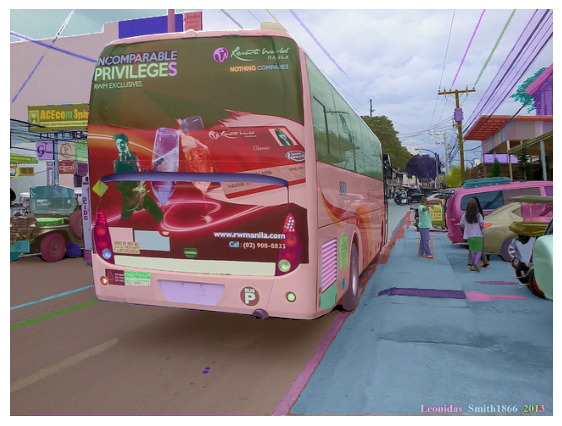

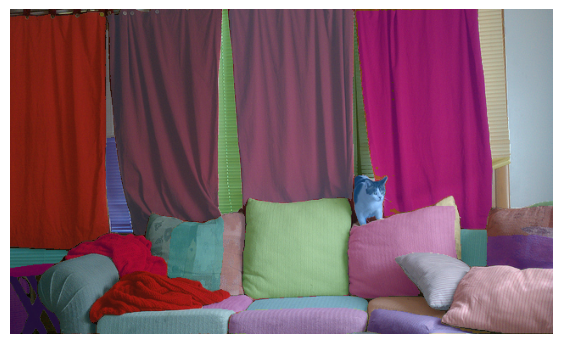

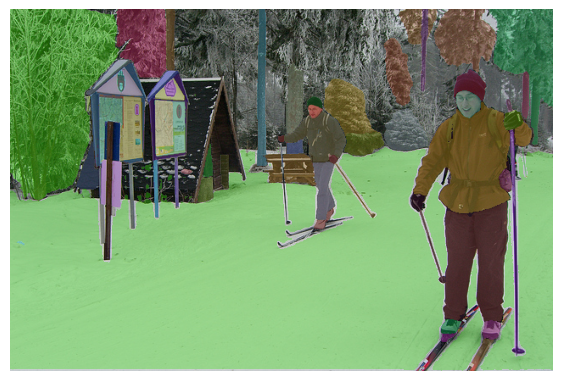

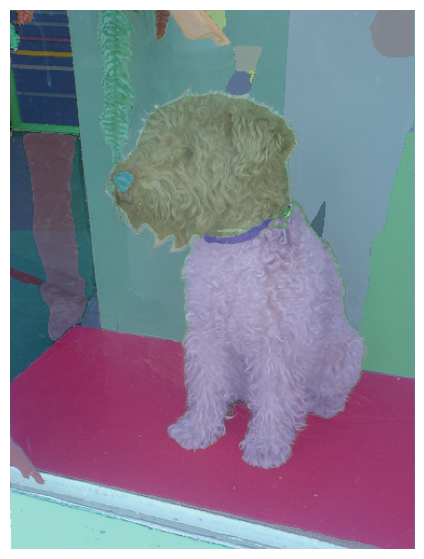

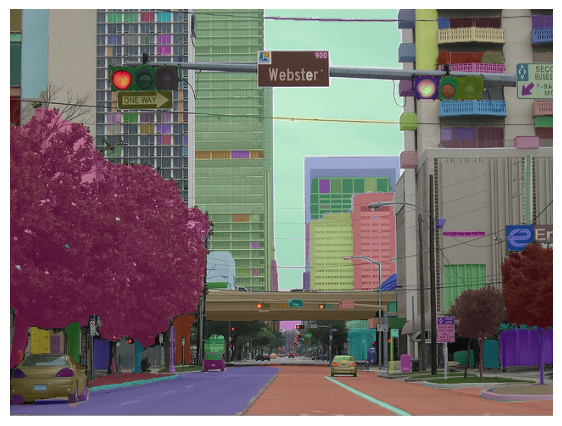

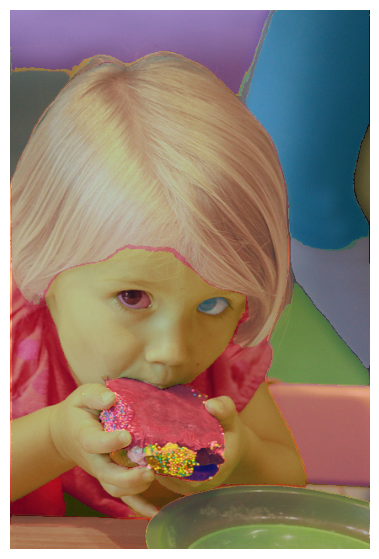

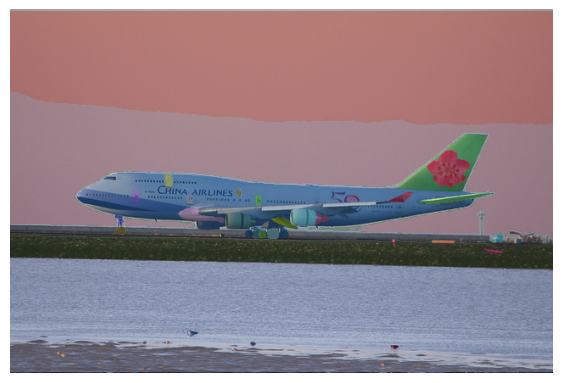

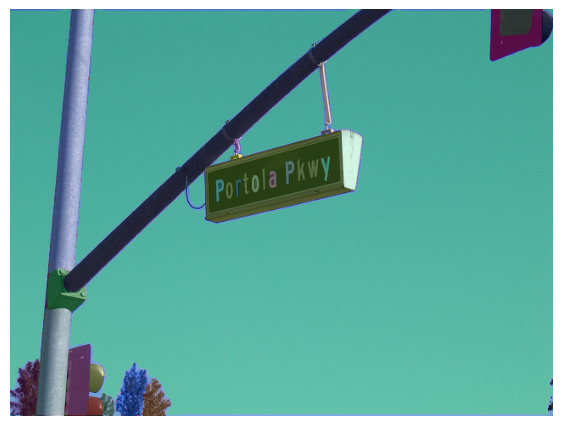

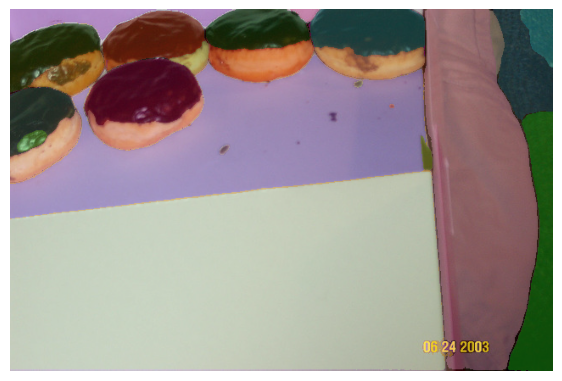

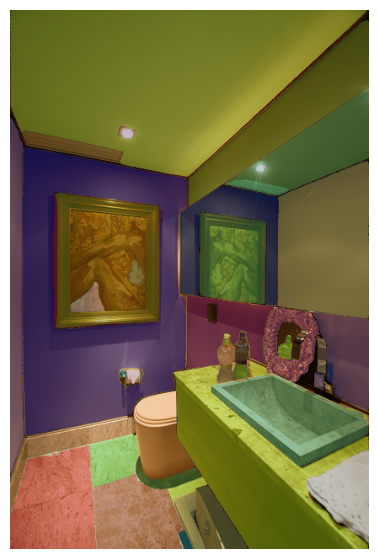

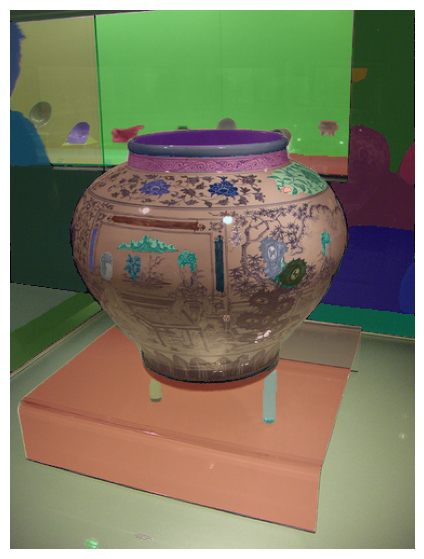

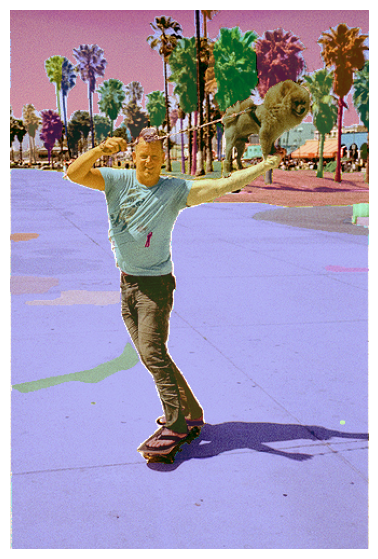

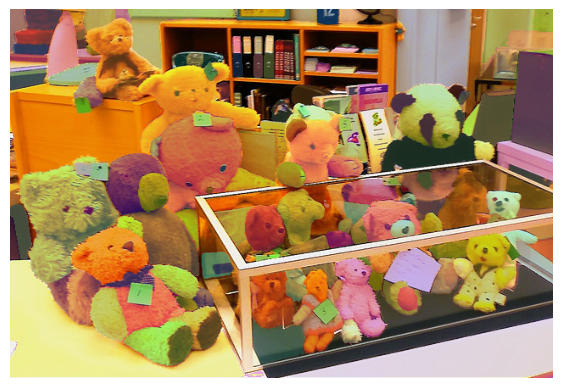

In [10]:
for image, mask in zip(images, predictions):
    plt.figure(figsize=(7,7))
    plt.imshow(image)
    show_anns(mask)
    plt.axis('off')
    plt.show()